# Создание функции для подбора чая

Теперь когда у нас есть две модели: для определния возраста и для определения настроения объеденим их в одной функции.

Первоначально как и всегда импортируем все библиотеки и подключим видеокарту.

In [2]:
import os
# Установка путей к CUDA 13.0
cuda_path = r'C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v13.0'
os.environ['CUDA_PATH'] = cuda_path

# Добавление необходимых путей в PATH
cuda_bin = os.path.join(cuda_path, 'bin')
cuda_libnvvp = os.path.join(cuda_path, 'libnvvp')

# Добавляем пути в начало PATH для приоритета
os.environ['PATH'] = cuda_bin + os.pathsep + cuda_libnvvp + os.pathsep + os.environ['PATH']

print("Пути CUDA 13.0 установлены!")

import shutil
from PIL import Image
import tensorflow as tf

import torch
print(f"CUDA доступна: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Версия CUDA в PyTorch: {torch.version.cuda}")
    print(f"Количество GPU: {torch.cuda.device_count()}")
    print(f"Имя устройства: {torch.cuda.get_device_name()}")

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import models, transforms, datasets
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet50_Weights
from collections import Counter
import re
import time
from tqdm import tqdm
import gc
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

Пути CUDA 13.0 установлены!
CUDA доступна: True
Версия CUDA в PyTorch: 12.1
Количество GPU: 1
Имя устройства: NVIDIA GeForce RTX 4070
Используется устройство: cuda


Для загрузки модели надо воссоздать архитектуру обученных моделей. Перенесем архитектуры.

In [3]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        
        self.features = nn.Sequential(
            # Блок 1
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            
            # Блок 2
            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            # Блок 3
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            # Блок 4
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(128, 256, kernel_size=5, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(256, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128, 4)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [4]:
class ResNet50FineTuned(nn.Module):
    def __init__(self):
        super(ResNet50FineTuned, self).__init__()
        
        self.backbone = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        
        for name, param in self.backbone.named_parameters():
            if 'layer4' in name or 'fc' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False 

        
        num_ftrs = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 97)
        )
    
    def forward(self, x):
        return self.backbone(x)

    def unfreezze_cnn_layer(self):
        
        for name, param in self.backbone.named_parameters():
            if 'layer3' in name :
                param.requires_grad = True 
            else:
                param.requires_grad = False 

    def unfreezze_all_layer(self):
        
        for name, param in self.backbone.named_parameters():
            param.requires_grad = True 


Теперь напишем функцию для загрузки моделей в наши созданные шаблоны и загрузим лучшие модели.

In [5]:
def load_model_for_training(checkpoint_path, model_class):

    # Загружаем чекпоинт
    checkpoint = torch.load(checkpoint_path)
    
    # Создаем модель той же архитектуры
    model = model_class()
    
    # Загружаем веса модели
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Создаем оптимизатор
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Загружаем состояние оптимизатора
    if 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    # Информация из чекпоинта
    epoch = checkpoint.get('epoch', 0)
    train_loss = checkpoint.get('train_loss', 0)
    val_loss = checkpoint.get('val_loss', 0)
    train_acc = checkpoint.get('train_acc', 0)
    val_acc = checkpoint.get('val_acc', 0)
    classes = checkpoint.get('classes', [])
    
    print(f"Модель загружена из: {checkpoint_path}")
    print(f"Эпоха: {epoch}")
    print(f"Val loss: {val_loss:.4f}, Val accuracy: {val_acc:.4f}")
    
    return model, optimizer, checkpoint

In [6]:
model_age, opt_age, check_age = load_model_for_training('best_model_093_age.pth', ResNet50FineTuned)

Модель загружена из: best_model_093_age.pth
Эпоха: 11
Val loss: 0.4788, Val accuracy: 0.9198


In [7]:
model_mood, opt_mood, check_mood = load_model_for_training('best_model_084_mood.pth', CNNClassifier)

Модель загружена из: best_model_084_mood.pth
Эпоха: 26
Val loss: 0.3796, Val accuracy: 0.8392


Модели загружены! Так как модель предсказывает только номер класса, теперь нужны названия классов - возьмем их из папки с тренировочной выборкой.

In [8]:
path = 'C:/Users/User/Desktop/Нейронка для чая/data_split/train'
class_names = []

for item in os.listdir(path):
    full_name = os.path.join(path, item)
    if os.path.isdir(full_name):
        class_names.append(item)

print(class_names)

['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '092', '093', '095', '096', '099', '100', '110']


In [9]:
path = 'C:/Users/User/Desktop/Нейронка для чая/data/train'
mood_class_names = []

for item in os.listdir(path):
    full_name = os.path.join(path, item)
    if os.path.isdir(full_name):
        mood_class_names.append(item)

print(mood_class_names)

['angry', 'happy', 'sad', 'surprise']


Загрузим заранее составленный набор данных для тестирования функции подбора чая.

In [13]:
BASE_PATH = r"C:\Users\User\Desktop\Нейронка для чая"
TEST_PATH = os.path.join(BASE_PATH, "Тест чая")

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(
    root=TEST_PATH,
    transform=test_transform
)

BATCH_SIZE = 256
NUM_WORKERS = 0

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

И наконец напишем функцию для подбора чая, в которую будет передоваться настроение и возраст - с учетом настроения будет подбирается чай и если будут некоторые ограничения по возрасту, будет выводить возможную альтернативу.

In [14]:
def tea_recommendation(mood, age = None, health_conditions = None):
    
    # База данных рекомендаций по настроениям
    tea_database = {
        'angry': {
            'name': 'Мятный, ромашковый или лавандовый чай',
            'description': 'Эти травы обладают седативным, успокаивающим эффектом. Помогают снять напряжение и внутреннее раздражение.',
            'action': 'Охлаждает, успокаивает ум, снимает мышечное напряжение',
            'caffeine_level': 'очень низкий',
            'suitable_for_children': True
        },
        'happy': {
            'name': 'Зелёный чай, светлый улун или фруктовый чай',
            'description': 'Лёгкие, свежие чаи с ярким ароматом идеально дополняют состояние радости.',
            'action': 'Поддерживает энергию, усиливает ощущение свежести и легкости',
            'caffeine_level': 'средний (зелёный, улун) / отсутствует (фруктовый)',
            'suitable_for_children': False 
        },
        'sad': {
            'name': 'Чай с имбирём и лимоном, чёрный чай или пряный чай с корицей',
            'description': 'Согревающие и тонизирующие напитки дарят ощущение уюта и поддержки.',
            'action': 'Согревает, мягко тонизирует, дарит чувство комфорта',
            'caffeine_level': 'средний-высокий (чёрный чай) / низкий (травяной)',
            'suitable_for_children': False
        },
        'surprise': {
            'name': 'Белый чай, жасминовый чай или лимонная вербена',
            'description': 'Деликатные чаи с тонким вкусом помогают осмыслить новую информацию.',
            'action': 'Проясняет ум, помогает сфокусироваться, приводит в состояние осознанности',
            'caffeine_level': 'низкий (белый чай) / отсутствует (травяной)',
            'suitable_for_children': 'с осторожностью'
        }
    }
    
    # Проверка корректности настроения
    mood_lower = mood.lower()
    if mood_lower not in tea_database:
        valid_moods = list(tea_database.keys())
        return {
            'error': f'Неизвестное настроение. Доступные варианты: {valid_moods}',
            'recommendation': None
        }
    
    recommendation = tea_database[mood_lower].copy()
    recommendation['mood'] = mood_lower
    
    warnings = []
    alternatives = []
    
    # Проверка возрастных ограничений
    if age is not None:
        if age < 3:
            warnings.append("Детям до 3 лет рекомендуются только специальные детские травяные/фруктовые чаи без кофеина.")
            alternatives.append("Детский ромашковый, фенхелевый чай или слабый настой шиповника")
            
            # Для малышей переопределяем рекомендацию на безопасную
            if mood_lower in ['angry', 'sad', 'surprise']:
                alternatives.append("Слабый ромашковый чай (успокаивающий)")
            elif mood_lower == 'happy':
                alternatives.append("Фруктово-ягодный чай без кофеина")
                
        elif 3 <= age <= 5:
            warnings.append(f"Детям 3-5 лет чай '{recommendation['name']}' не рекомендуется из-за кофеина.")
            if not recommendation['suitable_for_children']:
                alternatives.append("Слабый травяной чай, соответствующий вашему настроению")
                
        elif 6 <= age <= 12:
            if not recommendation['suitable_for_children']:
                warnings.append(f"Детям 6-12 лет чай '{recommendation['name']}' можно давать в очень слабой концентрации, не чаще 1-2 раз в неделю и только в первой половине дня.")
                alternatives.append(f"Разбавленный {recommendation['name']} (1/3 крепости) или травяная альтернатива")
        
        elif age > 60:
            if recommendation['caffeine_level'] in ['средний', 'высокий', 'средний-высокий']:
                warnings.append(f"Людям старше 60 лет рекомендуется пить некрепкий вариант чая '{recommendation['name']}' в первой половине дня.")
                alternatives.append(f"Слабая заварка {recommendation['name']} или белый чай как более мягкая альтернатива")
    
    if health_conditions:
        conditions_lower = [cond.lower() for cond in health_conditions]
        
        # Гипертония, проблемы с сердцем
        heart_related = ['гипертония', 'давление', 'гипертензия', 'аритмия', 'тахикардия', 'сердце']
        if any(cond in conditions_lower for cond in heart_related):
            if recommendation['caffeine_level'] in ['средний', 'высокий', 'средний-высокий']:
                warnings.append("При проблемах с давлением или сердцем ограничьте крепкий чай. Пейте слабую заварку.")
                alternatives.append("Травяные чаи без кофеина: иван-чай, ромашковый, липовый")
        
        # Проблемы с ЖКТ
        stomach_related = ['гастрит', 'язва', 'желудок', 'изжога', 'кислотность']
        if any(cond in conditions_lower for cond in stomach_related):
            warnings.append("При проблемах с ЖКТ избегайте крепкого чая натощак.")
        
        # Анемия
        if 'анемия' in conditions_lower:
            warnings.append("При анемии не пейте чай во время или сразу после еды (мешает усвоению железа).")
        
        # Бессонница
        if 'бессонница' in conditions_lower:
            if recommendation['caffeine_level'] in ['средний', 'высокий', 'средний-высокий']:
                warnings.append("При бессоннице пейте этот чай только в первой половине дня.")
    
    if health_conditions and any(cond in ['беременность', 'беременна', 'кормление', 'лактация'] for cond in [c.lower() for c in health_conditions]):
        if recommendation['caffeine_level'] in ['средний', 'высокий', 'средний-высокий']:
            warnings.append("При беременности и кормлении ограничьте кофеинсодержащие чаи до 1 чашки в день.")
            alternatives.append("Фруктово-ягодные чаи без кофеина, слабый имбирный или ромашковый чай")
    
    if warnings:
        recommendation['warnings'] = warnings
    if alternatives:
        recommendation['alternatives'] = alternatives
    
    recommendation['general_advice'] = "Наслаждайтесь процессом заваривания: неспешные, осознанные действия — лучшая терапия."
    
    return recommendation


И теперь проведем полноценный тест - будем выводить фотографию с возрастом и настроением, а в блоке ниже выводить чайные рекомендации.

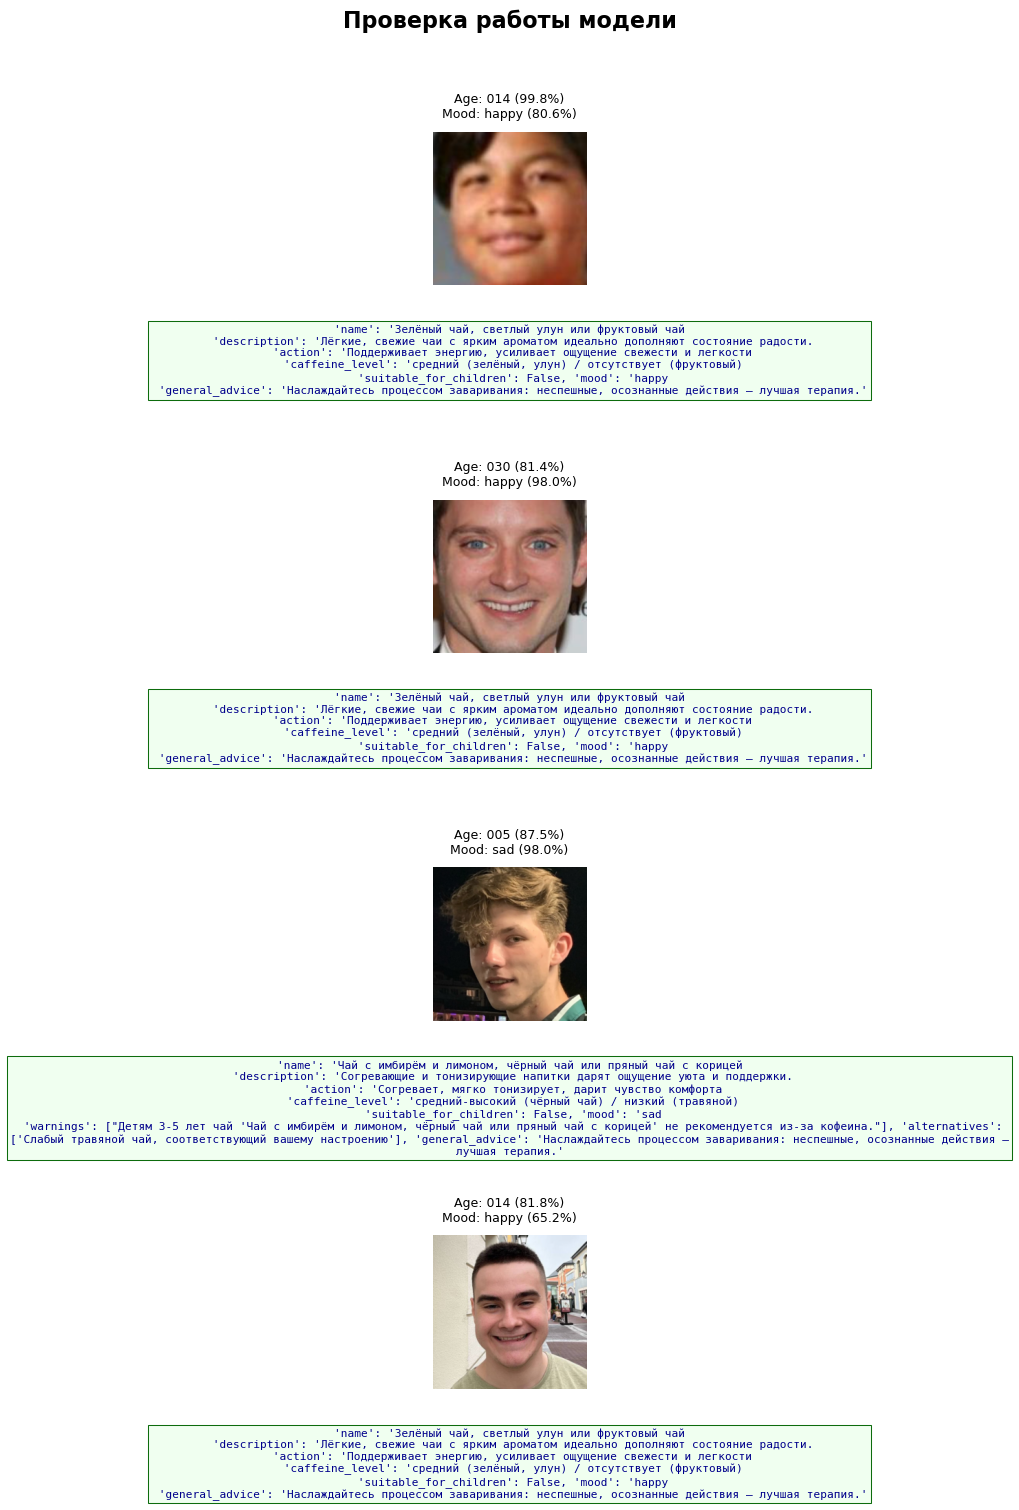

In [15]:
model_age = model_age.to(device)
model_mood = model_mood.to(device)

model_age.eval()
model_mood.eval()

dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images.to(device)

with torch.no_grad():
    outputs_age = model_age(images)
    outputs_mood = model_mood(images)
    
    probs_age = F.softmax(outputs_age, dim=1)
    conf_age, preds_age = torch.max(probs_age, 1)
    

    probs_mood = F.softmax(outputs_mood, dim=1)
    conf_mood, preds_mood = torch.max(probs_mood, 1)

images_cpu = images.cpu()
preds_age = preds_age.cpu()
conf_age = conf_age.cpu()
preds_mood = preds_mood.cpu()
conf_mood = conf_mood.cpu()
labels_cpu = labels.cpu()

num_images = min(10, len(images))
fig, axes = plt.subplots(num_images, 1, figsize=(10, 15))

axes = axes.flatten()

for i in range(num_images):
    ax = axes[i]
    
    img = images_cpu[i].numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img * std + mean
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    ax.axis('off')
    
    true_label = labels_cpu[i].item()
    pred_age = preds_age[i].item()
    pred_mood = preds_mood[i].item()
    
    true_class = class_names[true_label] if true_label < len(class_names) else f"Class_{true_label}"
    pred_age_class = class_names[pred_age] if pred_age < len(class_names) else f"Class_{pred_age}"
    
    pred_mood_class = mood_class_names[pred_mood] if pred_mood < len(mood_class_names) else f"Mood_{pred_mood}"
    
    conf_age_val = conf_age[i].item()
    conf_mood_val = conf_mood[i].item()
    
    age_color = 'black'
    
    title = f"Age: {pred_age_class} ({conf_age_val:.1%})\n"
    title += f"Mood: {pred_mood_class} ({conf_mood_val:.1%})"
    
    ax.set_title(title, color=age_color, fontsize=9, pad=10)

    recommendation = tea_recommendation(pred_mood_class, int(pred_age_class))
    recommendation = str(recommendation).replace('{', '').replace('}', '').split("',")
    recommendation = "\n".join(recommendation)

    ax.text(0.5, -0.25, recommendation, 
            transform=ax.transAxes, 
            fontsize=8,
            color='darkblue',
            ha='center', 
            va='top',
            bbox=dict(boxstyle='square,pad=0.3',
                     facecolor='honeydew', 
                    alpha=0.95,
                     edgecolor='darkgreen', 
                     linewidth=0.75),
            wrap=True,
            family='monospace')

for i in range(num_images, len(axes)):
    axes[i].axis('off')

plt.suptitle("Проверка работы модели", 
             fontsize=16, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()

Теперь видно процесс работы и модели, и функции. Сразу видно некоторые проблемы - определение возраста и настроения для людей СНГ происходят немного странно, хотя это можно объеснить выборкой, в выборке люди только из Европы и Америки.